In [1]:
import sys

## Update this to have the path to extreme-deconvolution's python library

In [2]:
sys.path.append('/mnt/home/mcranmer/extreme-deconvolution/py')

In [3]:
import lib.toy_data as toy_data
import lib.utils as utils
from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from train_misc import build_model_tabular

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

import pandas as pd
import numpy as np

In [5]:
raw_np = np.load('quick_isochrone.npy')
raw_np = raw_np

raw = pd.DataFrame({'G': raw_np[:, 0], 'bp_rp': raw_np[:, 1]})

#Add some noise:

raw['g_std'] = np.random.rand(len(raw))*0.3 + 1e-3
raw['bp_rp_p'] = raw['bp_rp'] + raw['g_std']*np.random.randn(len(raw))
raw['G_p'] = raw['G'] + raw['g_std']*np.random.randn(len(raw))


In [6]:
N = len(raw)
N

100000

In [7]:
use_cols = ['G_p', 'bp_rp_p', 'g_std']#, 'BP', 'RP']
cond_cols = []

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

npdata = np.array(raw[use_cols + cond_cols])
ss.fit(npdata)
data = torch.from_numpy(npdata.astype(np.float32))

In [8]:
raw[use_cols + cond_cols].describe()

,G_p,bp_rp_p,g_std
count,100000.000000,100000.000000,100000.000000
mean,3.450542,0.105280,0.150976
std,1.308679,0.297733,0.086583
min,-4.597801,-1.325939,0.001005
25%,2.619935,-0.113447,0.075991
50%,3.711582,0.119584,0.151155
75%,4.494398,0.300445,0.225861
max,6.665896,2.966956,0.301000


In [9]:
traindataset = TensorDataset(data[:-(N//5)])
testdataset = TensorDataset(data[-(N//5):])
batch = 1024
train = DataLoader(traindataset, batch_size=batch, shuffle=True, drop_last=True)
test = DataLoader(testdataset, batch_size=batch, shuffle=False)

In [10]:
len(traindataset)/batch

78.125

In [11]:
from xdgmm import XDGMM

In [12]:
xd = XDGMM(128, method='Bovy')

## Takes a long time!

In [189]:
Xerr = np.eye(2)[np.newaxis]*(np.ones(len(raw))*np.array(raw['g_std']))[:, None, None]
xd.fit(np.array(raw[['bp_rp_p', 'G_p']]), Xerr=Xerr)

XDGMM(V=array([[[2.42983e-04, 3.18794e-04],
        [3.18794e-04, 2.29463e-03]],

       [[3.70063e-04, 2.73535e-04],
        [2.73535e-04, 1.87868e-03]],

       ...,

       [[1.32867e-04, 7.11324e-05],
        [7.11324e-05, 3.91100e-04]],

       [[4.16726e-04, 5.49551e-04],
        [5.49551e-04, 6.12832e-03]]]),
   filename=None, labels=None, method='Bovy',
   mu=array([[ 0.32538,  4.91439],
       [-0.11011,  2.79926],
       ...,
       [ 0.46244,  5.40689],
       [ 0.33544,  4.69366]]),
   n_components=128, n_iter=1000000000, random_state=None, tol=1e-05,
   w=0.0,
   weights=array([3.42904e-02, 3.21448e-02, ..., 6.49799e-06, 3.20127e-11]))

In [13]:
from matplotlib import pyplot as plt

In [14]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

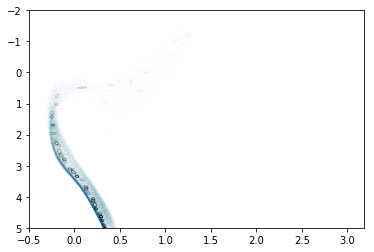

In [192]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*np.array(raw[['bp_rp', 'G']]).T, s=0.1, alpha=0.01)
plotXdgmm(xd, ax)
ax.set_ylim(5, -2)
plt.show()

In [15]:
# model.cpu()
# model.load_state_dict(torch.load(open('cur_best_modelv5.pt', 'rb')))
# model.cuda();

In [16]:
import pickle as pkl

In [17]:
args = pkl.load(open('args.pkl', 'rb'))

In [18]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, 2, regularization_fns).cuda()

In [19]:
if args.spectral_norm: add_spectral_norm(model)
set_cnf_options(args, model)

In [20]:
from torch import optim

In [21]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [22]:
transform_scale = torch.from_numpy(ss.scale_).float().cuda()[np.newaxis, :2]
transform_mean = torch.from_numpy(ss.mean_).float().cuda()[np.newaxis, :2]

def compute_loss(args, model, X, batch_size=None):
    if batch_size is None: batch_size = args.batch_size
    X = X.cuda()
    _Xerr = X[:, [2]]
    X = X[:, :2]
    X = X + torch.randn(*X.shape).cuda()*_Xerr[:, [0, 0]]

    x = (X-transform_mean)/transform_scale
#     return X
    # load data
#     x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
#     x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx/_Xerr**2)
    return loss

In [23]:
from lib import utils

In [24]:
import time

In [25]:
time_meter = utils.RunningAverageMeter(0.93)
loss_meter = utils.RunningAverageMeter(0.93)
nfef_meter = utils.RunningAverageMeter(0.93)
nfeb_meter = utils.RunningAverageMeter(0.93)
tt_meter = utils.RunningAverageMeter(0.93)

In [26]:
model.load_state_dict(
    torch.load('demo_model_ode_flow_v9.pt')
);

In [27]:
itr = 0

In [28]:
model = model.cuda()
model.train();

# You can skip this:

In [181]:
end = time.time()

while itr < 10000:

    for (X,) in train:
        optimizer.zero_grad()

        if args.spectral_norm: spectral_norm_power_iteration(model, 1)

        loss = compute_loss(args, model, X)

        loss_meter.update(loss.item())
        total_time = count_total_time(model)
        nfe_forward = count_nfe(model)
        loss.backward()
        optimizer.step()

        itr += 1

        if itr % 50 == 0:
            nfe_total = count_nfe(model)
            nfe_backward = nfe_total - nfe_forward
            nfef_meter.update(nfe_forward)
            nfeb_meter.update(nfe_backward)

            time_meter.update(time.time() - end)
            tt_meter.update(total_time)

            log_message = (
                'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f}) | NFE Forward {:.0f}({:.1f})'
                ' | NFE Backward {:.0f}({:.1f}) | CNF Time {:.4f}({:.4f})'.format(
                    itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, nfef_meter.val, nfef_meter.avg,
                    nfeb_meter.val, nfeb_meter.avg, tt_meter.val, tt_meter.avg
                )
            )
            print(log_message)

Iter 9050 | Time 6.7040(363.5875) | Loss 3273.018799(2713.182990) | NFE Forward 50(54.8) | NFE Backward 57(57.4) | CNF Time 0.5000(0.5000)
Iter 9100 | Time 43.0567(341.1503) | Loss 2771.172363(2337.272430) | NFE Forward 56(54.9) | NFE Backward 57(57.4) | CNF Time 0.5000(0.5000)
Iter 9150 | Time 80.1062(322.8772) | Loss 4820.059570(2919.115899) | NFE Forward 56(54.9) | NFE Backward 63(57.8) | CNF Time 0.5000(0.5000)
Iter 9200 | Time 117.2734(308.4850) | Loss 1171.560669(2295.947064) | NFE Forward 56(55.0) | NFE Backward 57(57.8) | CNF Time 0.5000(0.5000)
Iter 9250 | Time 154.0932(297.6775) | Loss 5607.152832(3025.931270) | NFE Forward 56(55.1) | NFE Backward 57(57.7) | CNF Time 0.5000(0.5000)
Iter 9300 | Time 190.6801(290.1877) | Loss 2057.475098(2223.106653) | NFE Forward 56(55.1) | NFE Backward 57(57.7) | CNF Time 0.5000(0.5000)
Iter 9350 | Time 226.9266(285.7594) | Loss 270.554871(2393.852262) | NFE Forward 56(55.2) | NFE Backward 57(57.6) | CNF Time 0.5000(0.5000)
Iter 9400 | Time 2

KeyboardInterrupt: 

In [29]:
# torch.save(model.cpu().state_dict(), open('demo_model_ode_flow_v9.pt', 'wb'))

# model.cpu();

In [30]:
from matplotlib import pyplot as plt

In [31]:
ss.mean_, ss.scale_

(array([3.45054211, 0.10528033, 0.15097625]),
 array([1.30867209, 0.29773135, 0.08658262]))

In [32]:
model = model.cpu()
model.eval();

In [33]:
from torch.functional import F

In [222]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    
    return logpx

def soft_lo_clamp(x, lo):
    return F.softplus(x-lo) + lo

# for age in np.linspace(9.1, 9.9, num=10):
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5*2, 5*2))
# ax = ax.ravel()
model#.cuda()
minG = -2#np.percentile(raw['G'], 3)
maxG = 5#np.percentile(raw['G'], 100-3)
minbprp = -0.5#np.percentile(raw['bp_rp'], 3)
maxbprp = 1#np.percentile(raw['bp_rp'], 100-3)
num = 100
pG, pbprp = np.meshgrid(np.linspace(minG, maxG, num=num), np.linspace(minbprp, maxbprp, num=num))
pG = pG.reshape(-1)
pbprp = pbprp.reshape(-1)

pdatap = np.zeros((len(pG), len(use_cols) + len(cond_cols)), dtype=np.float32)
pdatap[:, 0] = pG
pdatap[:, 1] = pbprp

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()
logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()
logprob_xd = soft_lo_clamp(
    torch.from_numpy(np.log(np.exp(xd.logprob_a(pdatap[:, [1, 0]], 0.0*np.eye(2)[np.newaxis]*np.ones(len(pdatap[:]))[:, None, None])).sum(1))), -100).numpy()

_exp = lambda _x: np.exp(_x/4)
prob_xd = _exp(logprob_xd.reshape(num, num))
prob = _exp(logprob.reshape(num, num))

/mnt/home/mcranmer/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)
/mnt/home/mcranmer/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


In [223]:
import matplotlib as mpl

In [224]:
from matplotlib.colors import Normalize

class CustomNorm(Normalize):
    def __init__(self, alpha, clip=False):
        # input levels
        self.alpha = alpha
        # corresponding normalized values between 0 and 1
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return (value/value.max())**self.alpha#(np.log10((value)+1e-10)+10)/10/1.013 

    def inverse(self, value):
        return 1.0 - self.__call__(value)

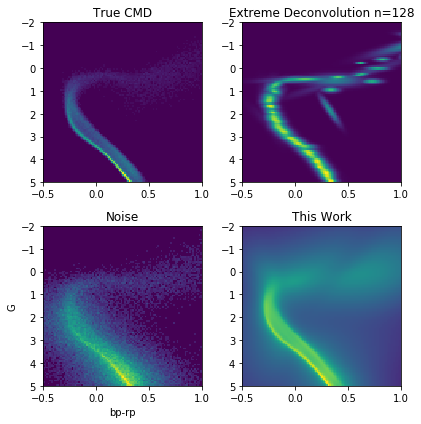

In [225]:
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
ax = ax.ravel()
norm = CustomNorm(0.5)
# ax[0].scatter(*np.array(raw[['bp_rp', 'G']]).T, s=0.1, alpha=0.1)
h, _, _, _ = ax[0].hist2d(raw['bp_rp'], raw['G'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[0].set_title('True CMD')
ax[2].hist2d(raw['bp_rp_p'], raw['G_p'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[2].set_title('Noise')
# plotXdgmm(xd, ax[1])


cax = ax[1]
cax.imshow(prob_xd.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('Extreme Deconvolution n=128')
cax = ax[3]
cax.imshow(prob.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('This Work')
# cax = ax[5]
# cax.imshow(np.abs(prob-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')
# cax = ax[2]
# cax.imshow(np.abs(prob_xd-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')

# cax.cbar()
ax[2].set_ylabel('G')
ax[2].set_xlabel('bp-rp')
for i in range(4):
    ax[i].set_ylim(5, -2)
    ax[i].set_xlim(minbprp, maxbprp)
# cax.set_title('feh_std=%f' % (feh_std,))

plt.tight_layout()
plt.savefig('t1.png', dpi=150)